<p style="background-color:#FDC759; color: black; font-family:newtimeroman; font-size:350%; text-align:center; border-radius: 15px 50px;"> CharaNet - Birdcall Classification 🦜</p>

In this notebook we are going to explore how to use Python and Neural Networks (NNs) to process audio signals and classify the different birds' calls. This is an open source dataset used for various experiments and analysis. It is also very interesting since we can learn a lot from audio signal tratment and also we are aplying to a real world use case.

The idea of the notebook is to showcase how to use modern libraries (Tensorflow in this case) to process and get value from real-world use-cases (and datasets). Let's start!

 <center><img src="./assets/bird_fly.png" alt="Bird Flying" width="350"></center>


In [1]:
!pip install tensorflow_hub tensorflow_io=="0.34.0" pydub tqdm librosa python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 4.8 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 7.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 7.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 5.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Atte

In [2]:
!apt-get update -qq && apt-get install ffmpeg -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf dbus i965-va-driver intel-media-va-driver
  libaacs0 libaom3 libapparmor1 libasound2 libasound2-data libass9 libasyncns0
  libavc1394-0 libavcodec58 libavdevice58 libavfilter7 libavformat58
  libavutil56 libbdplus0 libblas3 libbluray2 libbs2b0 libcaca0
  libcairo-gobject2 libcdio-cdda2 libcdio-paranoia2 libcdio19 libchromaprint1
  libcodec2-1.0 libdav1d5 libdbus-1-3 libdc1394-25 libdecor-0-0
  libdecor-0-plugin-1-cairo libdrm-amdgpu1 libdrm-common libdrm-intel1
  libdrm-nouveau2 libdrm-radeon1 libdrm2 libedit2 libelf1 libflac8 libflite1
  libgbm1 libgdk-pixbuf-2.0-0 libgdk-pixbuf2.0-bin libgdk-pixbuf2.0-common
  libgfortran5 libgl1 libgl1-amber-dri libgl1-mesa-dri libglapi-mesa libglvnd0
  libglx-mesa0 libglx0 libgme0 libgomp1 libgsm1 libicu70 libiec61883-0
  libigdgmm12 libjack-jackd2-0 liblapack3 libli

In [166]:
import os
from dotenv import load_dotenv
import glob
import math
import mlflow
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tqdm.notebook import tqdm
from tensorflow.keras import layers
from tensorflow.keras import models

from IPython import display
import IPython.display as ipd
from IPython.display import Audio
from scipy.io import wavfile
import librosa
import librosa.display as lid

import matplotlib
from matplotlib import pyplot as plt
from pydub import AudioSegment, effects
from pydub.generators import WhiteNoise
from multiprocessing.pool import ThreadPool

<p style="background-color:#FFD580; color: black; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;"> Data Ingestion 🗳</p>

### Data Information: 

The Data comes from the [CharaNet](https://www.kaggle.com/datasets/rayonegautam/charanet/data) Kaggle Dataset.

**CharaNet is a dataset of Nepal's endangered bird species audio files collected from xeno-canto.org.**

On the website xeno-canto.org, bird sounds from throughout the globe are shared. The recordings are uploaded on the website by the contributors who travel around. We collected 2215 audio recordings from this website of 41 birds of which 38 of them are listed as endangered species in Nepal. The dataset was increased to 6733 audio recordings after the 10-second split method for all and data augmentation through gaussian noise addition for birds having less than 30 files. A total of 5407 audio recordings were used for training, 639 for validation, and 687 for testing purposes.

In [115]:
dotenv_path = 'local.env'
load_dotenv(dotenv_path)

cmap = matplotlib.cm.get_cmap('coolwarm')

In [82]:
Train_Path = os.getenv("TRAIN_PATH")
Test_Path = os.getenv("TEST_PATH")
Validation_Path = os.getenv("VAL_PATH")

parsed_clip_folder_temp = Train_Path.split("/")
parsed_clip_folder_temp[int(os.getenv("PATH_REPLACE_POSITION"))] = "parsed_clips"
parsed_clips_folder = os.path.join(*parsed_clip_folder_temp[0:-1])

In [78]:
def generate_shorter_clips(raw_file_path):
    # Split bigger clips up into 3 second intervals for easier model training
    # Ideally this would be split to the actual bird calls but with enough data this should work too
    raw_path_list = raw_file_path.split("/")
    raw_audio_folder_path = os.path.join(*raw_path_list[0:-1])
    clips_folder_path_list = raw_path_list
    
    # Replace Kaggle folder with parsed_clips folder and make directory if it doesnt exist
    clips_folder_path_list[int(os.getenv("PATH_REPLACE_POSITION"))] = "parsed_clips"
    
    selected_clips_folder_path = os.path.join(*clips_folder_path_list[0:-1])
    os.makedirs(selected_clips_folder_path, exist_ok=True)
    parsed_file_name = raw_path_list[-1].split(".")[0]
    sound = AudioSegment.from_mp3(raw_file_path)
    
    # Get Count of ~ 3 second clips from file
    ms_to_s = 1000
    num_clips = math.floor(len(sound)/ms_to_s)//3
    if num_clips > 0:
        array_vals = np.array_split(np.array(range(len(sound))), num_clips)
        count = 0
        for clip in array_vals:
            start = int(clip[0])
            end = int(clip[-1])
            clip = sound[start:end]
            clip.export(
                os.path.join(selected_clips_folder_path, f"{parsed_file_name}-{count}.wav"), 
                format="wav"
            )
            count += 1
    else:
        sound.export(os.path.join(selected_clips_folder_path, f"{parsed_file_name}-0.wav"), format="wav")

In [77]:
species_list = os.listdir(Train_Path)
print("Generating Short Clips From Training Audio Files")
for species in tqdm(species_list,desc="Species Progress"):
    species_audio_files = os.listdir(os.path.join(Train_Path, species))
    for audio_file in tqdm(species_audio_files, leave=False, desc=f"{species} Progress"):
        # generate_shorter_clips(os.path.join(Train_Path, species, audio_file))
        pass

Generating Short Clips From Training Audio Files


Species Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Asian Koel Progress:   0%|          | 0/289 [00:00<?, ?it/s]

Black Kite Progress:   0%|          | 0/288 [00:00<?, ?it/s]

Black-breasted Parrotbill Progress:   0%|          | 0/42 [00:00<?, ?it/s]

Black-necked crane Progress:   0%|          | 0/82 [00:00<?, ?it/s]

Bristled Grassbird Progress:   0%|          | 0/52 [00:00<?, ?it/s]

Cheer Pheasant Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Common Cuckoo Progress:   0%|          | 0/416 [00:00<?, ?it/s]

Common Pochard Progress:   0%|          | 0/203 [00:00<?, ?it/s]

Common Wood Pigeon Progress:   0%|          | 0/376 [00:00<?, ?it/s]

Eastern Imperial Eagle Progress:   0%|          | 0/24 [00:00<?, ?it/s]

Egyptian Vulture Progress:   0%|          | 0/16 [00:00<?, ?it/s]

Great Slaty Woodpecker Progress:   0%|          | 0/152 [00:00<?, ?it/s]

Greater Spotted Eagle Progress:   0%|          | 0/205 [00:00<?, ?it/s]

Grey Treepie Progress:   0%|          | 0/267 [00:00<?, ?it/s]

Grey-crowned Prinia Progress:   0%|          | 0/24 [00:00<?, ?it/s]

Grey-sided Thrush Progress:   0%|          | 0/28 [00:00<?, ?it/s]

Himalayan Monal Progress:   0%|          | 0/76 [00:00<?, ?it/s]

House Crow Progress:   0%|          | 0/314 [00:00<?, ?it/s]

House Sparrow Progress:   0%|          | 0/316 [00:00<?, ?it/s]

Indian Spotted Eagle Progress:   0%|          | 0/14 [00:00<?, ?it/s]

Jerdon_s Babbler Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Kashmir Flycatcher Progress:   0%|          | 0/42 [00:00<?, ?it/s]

Large-billed Crow Progress:   0%|          | 0/284 [00:00<?, ?it/s]

Long-tailed Duck Progress:   0%|          | 0/179 [00:00<?, ?it/s]

Pallas_s Fish Eagle Progress:   0%|          | 0/14 [00:00<?, ?it/s]

Red-billed Blue Magpie Progress:   0%|          | 0/170 [00:00<?, ?it/s]

Rose-ringed Parakeet Progress:   0%|          | 0/243 [00:00<?, ?it/s]

Rufous Treepie Progress:   0%|          | 0/239 [00:00<?, ?it/s]

Rufous-necked Hornbill Progress:   0%|          | 0/36 [00:00<?, ?it/s]

Rustic Bunting Progress:   0%|          | 0/242 [00:00<?, ?it/s]

Saker Falcon Progress:   0%|          | 0/44 [00:00<?, ?it/s]

Sarus Crane Progress:   0%|          | 0/66 [00:00<?, ?it/s]

Satyr Tragopan Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Slender-billed Babbler Progress:   0%|          | 0/29 [00:00<?, ?it/s]

Spiny Babbler Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Spotted Dove Progress:   0%|          | 0/328 [00:00<?, ?it/s]

Steppe Eagle Progress:   0%|          | 0/18 [00:00<?, ?it/s]

Swamp Francolin Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Swamp Grass-babbler Progress:   0%|          | 0/44 [00:00<?, ?it/s]

White-throated Bushchat Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Wood Snipe Progress:   0%|          | 0/32 [00:00<?, ?it/s]

<p style="background-color:#FFD580; color: black; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;"> Data Augmentation 🪄</p>

Similar to Image Recognition in order to produce a robust model you may want to Augment your training set with transformed samples. Here are a few examples that can be used to transform audio clips.

In [7]:
def Add_White_Noise(sound, decibels = 50):
    """
    Add White Noise to an Audio Clip and return the new clip
    Note: sound should be an AudioSegment
    """
    noise = WhiteNoise().to_audio_segment(duration=len(sound))-decibels
    combined = sound.overlay(noise)
    return combined
    
def Normalize_Volume(sound):
    """
    Normalize the Volume of a Clip and return the new clip
    Note :sound should be an AudioSegment
    """
    normalized_sound = effects.normalize(sound) 
    return normalized_sound
    
def Filter_Out_High_Frequency(sound,cutoff = 8e3):
    """
    Filter out High Frequencies in a Clip and return the new clip
    Note: sound should be an AudioSegment and cutoff is in Hz (default is 8kHz)
    """
    filtered_sound = effects.low_pass_filter(sound,cutoff) 
    return filtered_sound
    
def Filter_Out_Low_Frequency(sound,cutoff = 8e3):
    """
    Filter out High Frequencies in a Clip and return the new clip
    Note: sound should be an AudioSegment and cutoff is in Hz (default is 8kHz)
    """
    filtered_sound = effects.high_pass_filter(sound,cutoff) 
    return filtered_sound

### Utility functions

In [125]:
class CFG:
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 32
    upsample_thr = 50 # min sample of each class (upsample)
    cv_filter = True # always keeps low sample data in train
    
    # Audio duration, sample rate, and length
    duration = 60 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    normalize = True

In [209]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=CFG.img_size[0],
                                   n_fft=CFG.nfft,
                                   hop_length=CFG.hop_length,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    return spec

def display_audio(filepath, label=None, pred=None):
    # Caption for viz
    caption = f'Name: {filepath.split("/")[-2]} | Label: {label} | Pred: {pred}'
    # Read audio file
    audio, sr = load_audio(filepath)
    # Keep fixed length audio
    # audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    ipd.display(ipd.Audio(audio, rate=CFG.sample_rate))

    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length = CFG.hop_length,
                 n_fft=CFG.nfft,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

In [210]:
file_paths = glob.glob(str(os.path.join(parsed_clips_folder, "train", '*/*.wav')), recursive=True)
file_path = random.choice(file_paths)
file_path

'../datafabric/parsed_clips/train/Long-tailed Duck/XC660261 1-0.wav'

# Audio:


# Visualization:


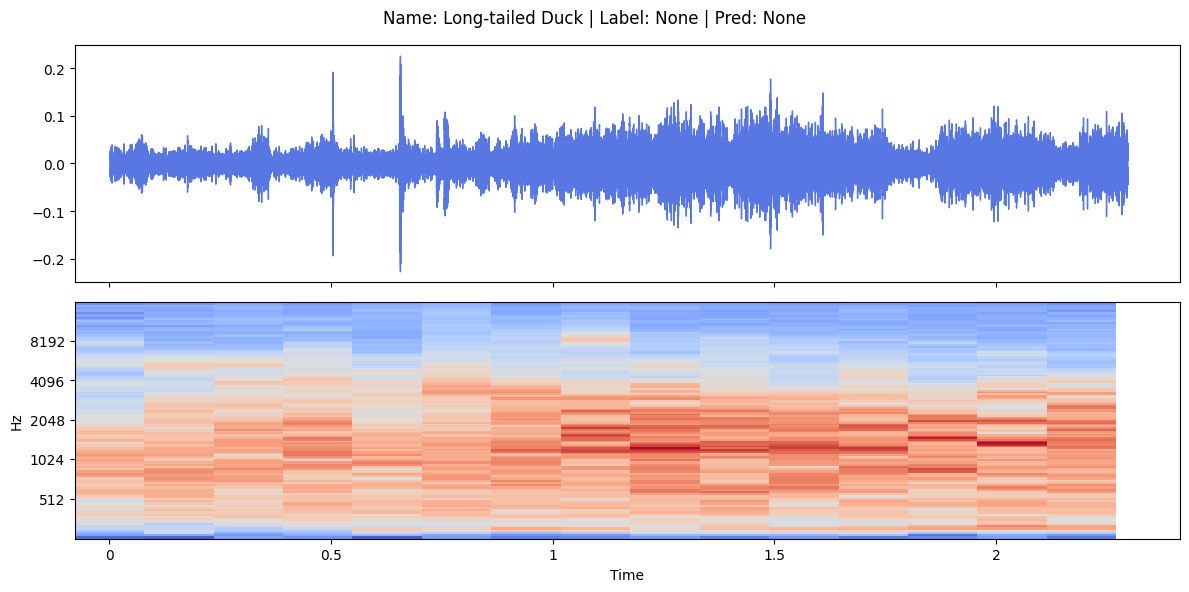

In [211]:
display_audio(file_path)

<p style="background-color:#FFD580; color: black; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;"> Prepare the model (Spectrograph and CNN)</p>

In [79]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary,desired_channels=1,)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)
    
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]
    
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label
    
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
    [16000] - tf.shape(waveform),
    dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
    equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram
    
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == label_list)
    return spectrogram, label_id
    
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [80]:
# Set the seed value for experiment reproducibility.
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [185]:
parsed_clips_dir = os.path.join(parsed_clips_folder, "train")
label_list = species_list
folders = os.listdir(parsed_clips_dir)
filenames = tf.io.gfile.glob(str(os.path.join(parsed_clips_dir, folders[0], '*')))

for folder in tqdm(folders[1:],desc="Loading Clips"):
    filenames_train = tf.io.gfile.glob(str(os.path.join(parsed_clips_dir, folder, '*')))
    filenames = tf.concat([filenames, filenames_train], 0)
#filenames_Not_Capuchinbird = tf.io.gfile.glob(str(data_dir) + '/Parsed_Not_Capuchinbird_Clips/*')

filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)

Loading Clips:   0%|          | 0/40 [00:00<?, ?it/s]

Number of total examples: 15140


In [186]:
train_split = int(.8*num_samples)
val_split = int(.1*num_samples)
test_split = num_samples - train_split - val_split
train_files = filenames[:train_split]
val_files = filenames[train_split: train_split + val_split]
test_files = filenames[-1*test_split:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 12112
Validation set size 1514
Test set size 1514


In [86]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [87]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

<p style="background-color:#FFD580; color: black; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;"> Train Custom CNN Model 🔬</p>

In [14]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 1024
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [15]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(label_list)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`. using only 10% for speed here.
norm_layer.adapt(data=spectrogram_ds.take(val_split).map(map_func=lambda spec, label: spec))

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

cnn_model.summary()

2024-03-17 21:40:18.491319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Input shape: (124, 129, 1)


2024-03-17 21:40:21.610559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │         5,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,868 (6.22 MB)

 Trainable params: 1,629,865 (6.22 MB)

 Non-trainable params: 3 (16.00 B)

In [16]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

#### Set up ML FLOW

In [17]:
mlflow.set_experiment(experiment_id="554820298018439438")

mlflow.autolog()

2024/03/17 21:40:21 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/03/17 21:40:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/03/17 21:40:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


#### Set up Tensorboard
Optional:

```
# Clear any logs from previous runs
rm -rf ./logs/
```

In [18]:
%load_ext tensorboard

log_dir = "/phoenix/tensorboard/tensorlogs/CNN_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
EPOCHS = 100

history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=5,
                                               monitor='val_loss',
                                               restore_best_weights=True
                                              ),
              tensorboard_callback],
)

2024/03/17 21:40:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3dc5e2fb37ab4962b2cd443163eef20d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024-03-17 21:40:44.924354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-17 21:40:47.848251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024/03/17 21:40:48 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: list.append() takes no keyword arguments


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.0758 - loss: 3.4938 - val_accuracy: 0.1539 - val_loss: 3.0770
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.1211 - loss: 3.1347 - val_accuracy: 0.1968 - val_loss: 2.9006
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.1607 - loss: 2.9612 - val_accuracy: 0.2569 - val_loss: 2.7695
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.2010 - loss: 2.8388 - val_accuracy: 0.2992 - val_loss: 2.6371
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.2239 - loss: 2.7258 - val_accuracy: 0.3065 - val_loss: 2.5503
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.2506 - loss: 2.6325 - val_accuracy: 0.3124 - val_loss: 2.4556
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.2703 - loss: 2.5526 - val_accuracy: 0.3263 - val_loss: 2.3897
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.2875 - loss: 2.4873 - val_accu

2024-03-17 21:43:06.300672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024/03/17 21:43:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmp1rnijq3q/model/data/model.


In [20]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(cnn_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

 8/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

2024-03-17 21:43:09.246649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test set accuracy: 44%


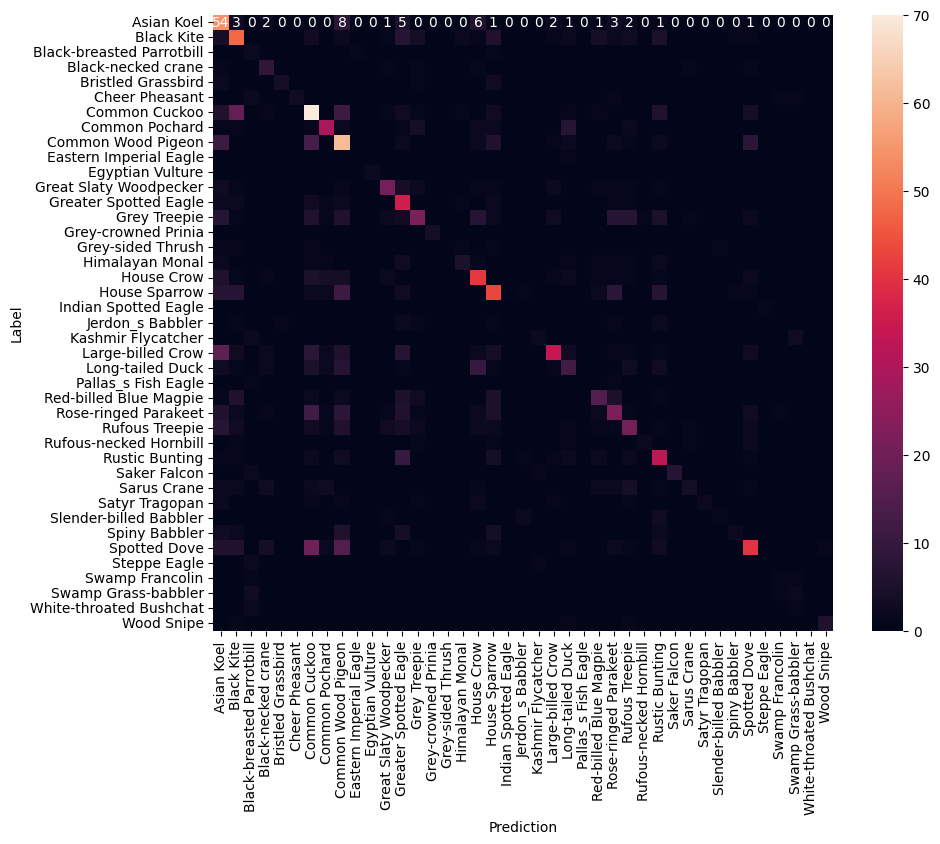

In [21]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_list,
            yticklabels=label_list,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [216]:
sample_file_from_test = 5
test_file = test_files[sample_file_from_test]
test_label = y_true[sample_file_from_test]
test_pred = y_pred[sample_file_from_test]
test_file_path = test_file.numpy().decode()
test_file_path, test_label

('../datafabric/parsed_clips/train/Grey Treepie/XC612009 13-0.wav', 1)

# Audio:


# Visualization:


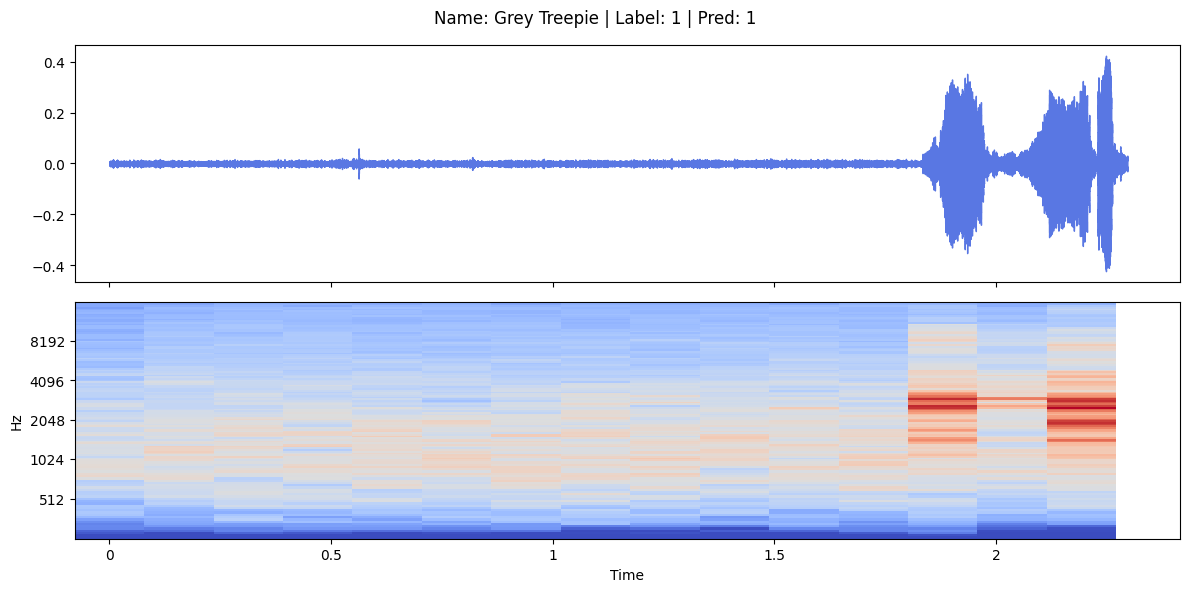

In [217]:
display_audio(test_file_path, test_label, test_pred)

<p style="background-color:#FFD580; color: black; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;"> Finetune YAMNet ⚖️</p>

In [22]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav
    
def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label
    
def extract_embedding(wav_data, label):
    """ run YAMNet to extract embedding from the wav data """
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings)
           )
    
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """ Split Train, Test and Validation Datasets out of Dataframe """
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=1842)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

# Filter out Annoying Tensorflow Warnings
tf.get_logger().setLevel('ERROR')

### Download YAMNet Model

In [23]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

### Build Training Set

In [24]:
parsed_clips_dir = os.path.join(parsed_clips_folder, "train")
label_list = species_list
dataset_df = pd.DataFrame()
for folder in tqdm(os.listdir(parsed_clips_dir),desc="Loading Clips"):
    species_filepath_list = []
    for file in os.listdir(os.path.join(parsed_clips_dir,folder)):
        if file.endswith('.wav'):
            species_filepath_list.append(os.path.join(parsed_clips_dir,folder,file))
    species_df = pd.DataFrame({"filename":species_filepath_list,"target":np.argmax(folder == label_list)})
    dataset_df = pd.concat([dataset_df,species_df],axis=0,ignore_index=True)

Loading Clips:   0%|          | 0/41 [00:00<?, ?it/s]

In [30]:
main_ds = tf.data.Dataset.from_tensor_slices((dataset_df["filename"], dataset_df["target"]))
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

NotImplementedError: in user code:

    File "/tmp/ipykernel_461/226343577.py", line 14, in load_wav_for_map  *
        return load_wav_16k_mono(filename), label
    File "/tmp/ipykernel_461/226343577.py", line 10, in load_wav_16k_mono  *
        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/audio_ops.py", line 469, in resample  **
        value = tf.vectorized_map(f, input)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/audio_ops.py", line 465, in f
        return core_ops.io_audio_resample(
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py", line 88, in __getattr__
        return getattr(self._load(), attrb)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py", line 84, in _load
        self._mod = _load_library(self._library)
    File "/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py", line 69, in _load_library
        raise NotImplementedError(

    NotImplementedError: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
    caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN4absl12lts_202301258StatusOrIN3tsl4core11RefCountPtrIS1_EEEEvEE']


In [ ]:
# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(main_ds,len(dataset_df))

train_ds = train_ds.cache().shuffle(1000).batch(512).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(512).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(512).prefetch(tf.data.AUTOTUNE)

#### Build Model 

In [ ]:
yamnet_transfer_learning_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_labels)
], name='yamnet_transfer_learning_model')

yamnet_transfer_learning_model.summary()

In [ ]:
yamnet_transfer_learning_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

%load_ext tensorboard

log_dir = "/phoenix/tensorboard/tensorlogs/YAMNet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            ]

In [ ]:
mlflow.set_experiment(experiment_id="961598678667043864")

mlflow.autolog()

In [ ]:
history = yamnet_transfer_learning_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callbacks)
